In [166]:
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import sys
from skimage.metrics import structural_similarity as ssim
from multiprocessing import Pool, Process, Manager
import time
import itertools
import operator
import pickle as pk
from skimage import filters

import autograd

In [285]:
X_train = np.loadtxt('../Data/X_train.csv')
X_test = np.loadtxt('../Data/X_test.csv')
Y_train = np.loadtxt('../Data/Y_train.csv')
Y_test = np.loadtxt('../Data/Y_test.csv')

In [483]:
def sigma(x):
    return 1/(1 + np.exp(x))

def lae(s, t):
    """
    Compute log add exp 
    Return log(exp(s) + exp(t))
    """
    return np.logaddexp(s, t)

def logp_conditional(y, x, z):
    """
    Compute condition logistic probability
    """
    return -lae(0, -y*(z@x))

def grad_logp_conditional(y, x, z):
    """
    Compute and return the gradient computed at z
    """
    grad = y*x*sigma(-y*(z@x))
    return grad

def int_estimate(y, x, w, dim=1, var=0.5, msize=2):
    """
    Single Point Estimate of Integral
    """
    ## Sample z_o from Normal distribution
    e_o = np.random.normal(0, 1, dim)
    e_o = np.reshape(e_o, (1, dim))
    z_o = np.sqrt(var)*e_o + w
    
    first_term = np.linalg.norm(z_o)**2
    third_term = np.log(np.sqrt(2*np.pi))
    
    samples = np.random.choice(range(len(y)), msize, replace=False)
    second_term = 0
    for sample_idx in samples:
        second_term += lae(0, -y[sample_idx]*(z_o@x[sample_idx]))
    second_term = (len(y)/msize)*second_term
    
    q_term = -np.exp(-0.5*np.linalg.norm(z_o)**2)/np.sqrt(2*np.pi*var)
    return q_term*(first_term + second_term + third_term)

def grad_int(y, x, w, dim=1, var=0.5, msize=2):
    """
    Return the gradient of the integral computed at w
    """
    e_o = np.random.normal(0, 1, dim)
    e_o = np.reshape(e_o, (1, dim))
    z_o = np.sqrt(var)*e_o + w
    
    grad = -z_o
    minibatch = np.random.choice(range(len(y)), msize, replace=False)
    batch_grad = np.zeros(np.shape(x[0]))
    for idx in minibatch:
        batch_grad += y[idx]*x[idx]*sigma(-y[idx]*(z_o@x[idx]))
    
    grad += (len(y)/msize)*batch_grad
    q_term = np.exp(-0.5*(np.linalg.norm(e_o)**2))/np.sqrt(2*np.pi)
    grad = q_term*grad
    return grad
    

In [286]:
np.random.seed(482)
dummy_x = np.array([[2, 1], [-1, 1], [-1, 1],[-1, 1],[-1, 1]])
dummy_y = np.array([-1, 1, 1, 1, 1])
dummy_w = np.array([1.0, 1.0])
dummy_w_2 = np.array([1.00, 1.0000])
dummy_w_3 = np.array([1.0000, 1.0001])
i1 = int_estimate(dummy_y, dummy_x, dummy_w, dim=len(dummy_w), msize=5)
i2 = int_estimate(dummy_y, dummy_x, dummy_w_2, dim=len(dummy_w), msize=5)
i3 = int_estimate(dummy_y, dummy_x, dummy_w_3, dim=len(dummy_w), msize=5)
print((i3-i1))
print((i2-i1))

-0.041611213639737236
-0.0006987487207564459
-0.20151912776741782
[-0.40272568]
[0.55978532]


In [479]:
def _int_estimate(w):
    return int_estimate(Y_train, X_train, w, len(w), msize=100)

np.random.seed(482)
grad_f = autograd.grad(_int_estimate)
wo = np.zeros(X_train.shape[1])
print(grad_f(wo))
print(grad_int(Y_train, X_train, wo, dim=len(wo), msize=100))

[10.61348736  9.72971582 -2.83331562 -9.8669262  14.4504671 ]
[[ 0.01708532  0.21604235 -0.70727651  0.73913333 -0.92146161]]


## Q4 Compute SGVI

In [484]:
def sgvi(_X_train, _Y_train, step_size=0.005, t_max=10000):
    w = np.zeros(_X_train.shape[1])
    w_history = []
    w_history.append(w)
    for t in range(0, t_max):
        g = grad_int(_Y_train, _X_train, w, dim=len(w), msize=20)
#         g = grad_f(w)
        w = w + step_size*g
        w_history.append(w[0])
    return w, w_history

In [485]:
np.random.seed(482)
wf, wh = sgvi(X_train, Y_train)
print(wf)

[[ 0.28475336  0.29688541  2.68581147 -1.63624589  2.09915984]]


In [486]:
#### Evaluate Int estimator
wo = np.zeros(X_train.shape[1])
print(int_estimate(Y_train, X_train, wo, msize=100))
print(int_estimate(Y_train, X_train, wf, msize=100))

[-34.60574516]
[-0.30320871]


In [487]:
wh = np.array(wh)
wh.shape

(10001, 5)

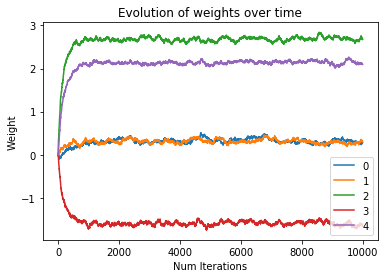

In [488]:
### Plot evolution of w
for d in range(0, 5):
    plt.plot(wh[:, d], label='{}'.format(d))
plt.xlabel('Num Iterations')
plt.ylabel('Weight')
plt.legend()
plt.title("Evolution of weights over time")
plt.savefig("evolq4.png")
plt.show()